<center > <h1 style="color:#0c343d;"&#x261A; >  MINI PROJET: Classification des images de MNIST. </h1> </center>

<h1 style='color:#134f5c'>Introduction:</h1><br>
Avez-vous déjà rencontré un jeu de données ou une image et vous avez demandé si vous pouvez créer un systéme capable de differencier ou d'identifier l'image? Alors <strong> le concept de classification d'image va nous y aider!!</strong>

### Qu'est ce que la classification des images?
La classification d'image est l'une des application les plus populaires de la vision par ordinateur. Prenons un exemple pour mieux le comprendre; Quand on fait la classification des images, notre systeme recevra une image en entrée, par exemple un chat, maintenant le systeme connaitra un ensemble de categories et son objectif est d'attribuer une categorie à l'image.

### Qu'est ce que MNIST?
la base de données MNIST (Changed National Organization of Benchmarks and Innovation database) est une énorme base de données <strong> specifique </strong> des chiffres écrits manuellement qui est normalement utilisée pour préparer différents systèmes de traitement d’images. La base de données est en outre généralement utilisée pour préparer et tester dans le domaine de l’apprentissage automatique. Elle a été réalisée en “remélangeant” les exemples des ensembles de données uniques du NIST

### L'objectif de ce projet :
Il a été demandé dans ce projet d'expérimenter avec les différents algorithmes d'apprentissage le jeu de données MNIST, qui comprend un grand nombre de données, pour effectuer à la fin le classement de ces données avec la meilleure méthode trouvée.<br>
Dans ce rapport, on présente les démarches suivies par notre équipe pour réaliser cette tache.<br> <br>
 On commence avec une description des differents outils permettant de réaliser le classements. Chaque descripteur est discutée en détail. Puis on présente nos résultats expérimentaux en visualisation et en test pour chaque outil.<br><br>
  Finalement, on présente une analyse comparative des résultats obtenus et on détermine l'approche qui a donnée les meilleures performances en calculant la precision.

<h1 style='color:#134f5c'>Réduction du nombre de donnée:</h1><br>
Lors de l'entrainement d'un algorithme, la bonne pratique veut qu'on découpe
notre jeu de données en jeu d'entrainement (training set) et jeu de test (testing set) pour reduire le nombre de données. Ainsi nous pourrons tester les performances du modele obtenu suite a l'entrainement de l'algorithme. Le test de performance se fait sur le testing set;<br>
Pour notre cas, on divisera notre jeu de données comme suit:<br> <strong>80%: training set</strong> <br> <strong>20%: testing set</strong>

In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2
import imutils
import csv

<strong>Extraction des images d'entrainement du fichier mnist_train.csv et visualisation.</strong> <br>
<strong>Remarque:</strong> veuillez changer le path avant d'executer la cellule.

In [26]:
train_data=pd.read_csv('D:\IRM Phase 2\BDM\mnist mini projet\dataset\mnist_train.csv')
selected_train_images={i:[]for i in range(10)}
for label in range(10):
    class_train_df=train_data[train_data['label']==label].iloc[:80]
    selected_train_images[label]=class_train_df.drop('label',axis=1).values.reshape(-1,28,28)
selected_train_images_=np.array([np.array(selected_train_images[i])for i in range(10)])
selected_train_images_NP=np.concatenate(selected_train_images_)
selected_train_images_NP.shape

(800, 28, 28)

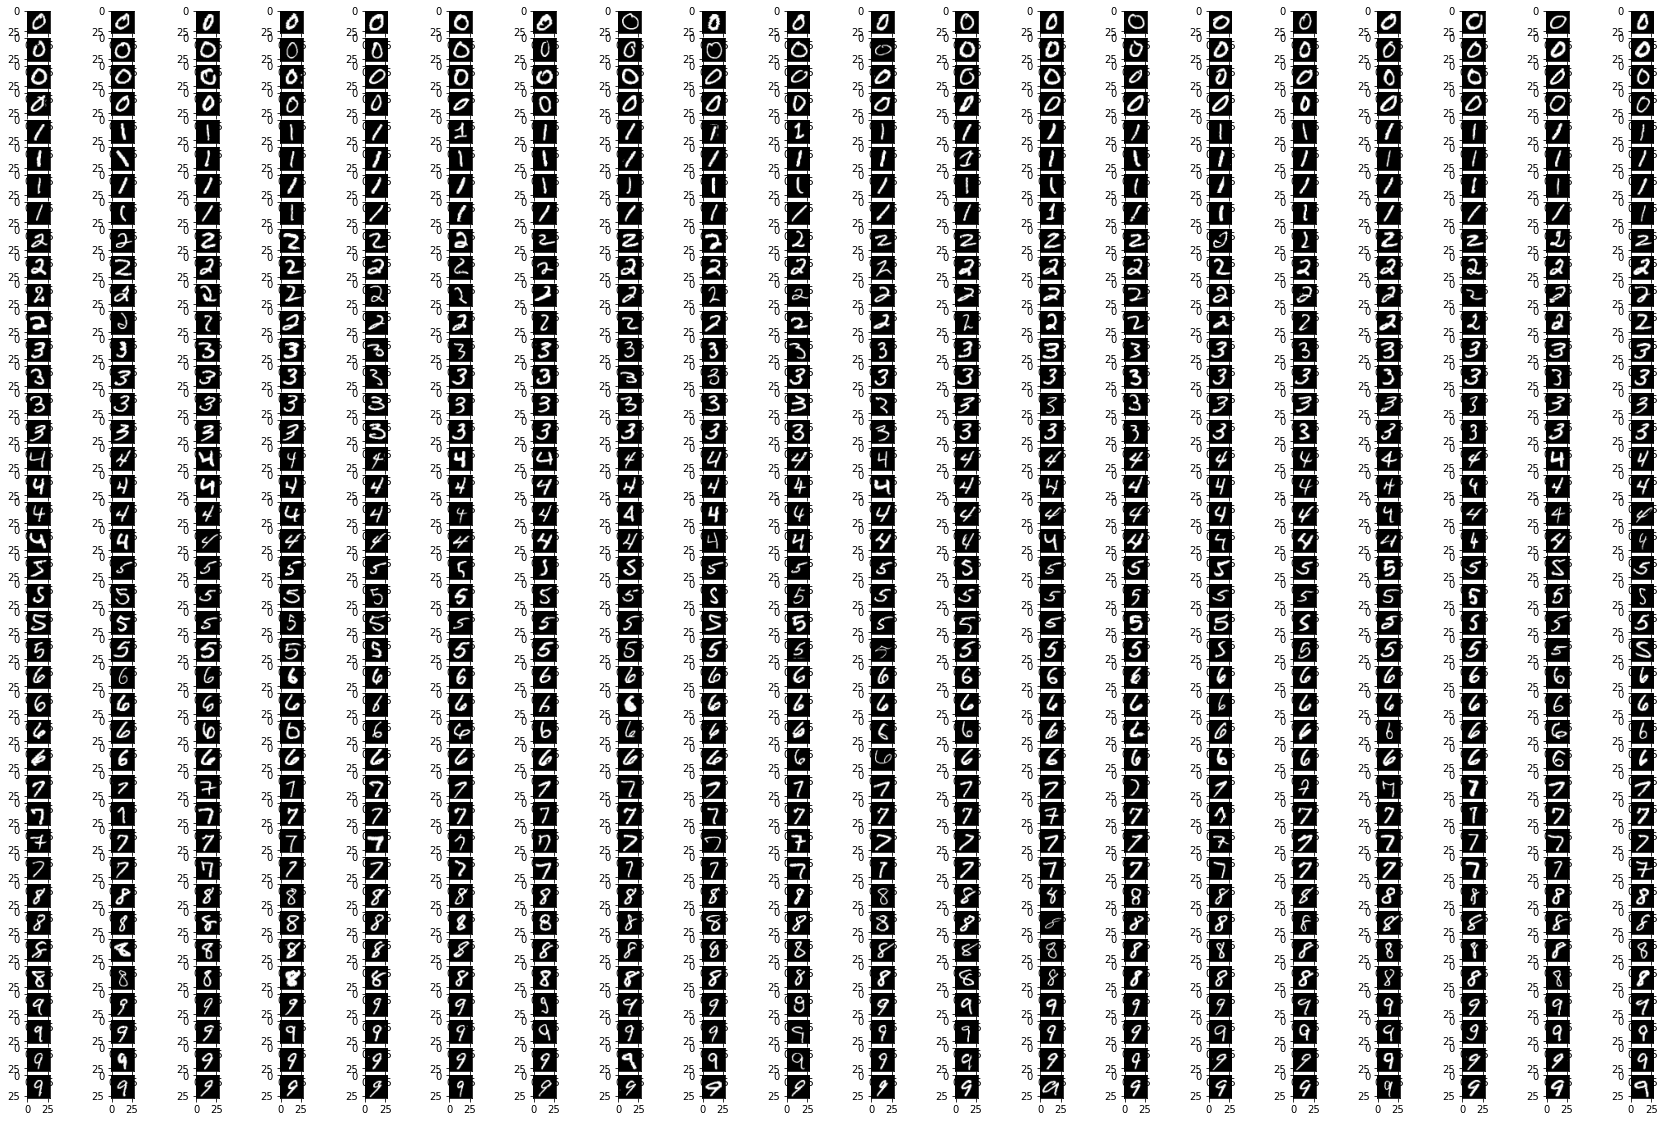

In [57]:
plt.figure(figsize=(30,20))
for i in range(800):
    plt.subplot(40,20,i+1)
    plt.imshow(selected_train_images_NP[i],"gray")

<strong>Extraction des images de test du fichier mnist_test.csv et visualisation.</strong><br>
<strong>Remarque:</strong> veuillez changer le path avant d'executer la cellule.

In [27]:
test_data=pd.read_csv('D:\IRM Phase 2\BDM\mnist mini projet\dataset\mnist_test.csv')
selected_test_images={i:[]for i in range(10)}
for label in range(10):
    class_test_df=test_data[test_data['label']==label].iloc[:20]
    selected_test_images[label]=class_test_df.drop('label',axis=1).values.reshape(-1,28,28)
selected_test_images_=np.array([np.array(selected_test_images[i])for i in range(10)])
selected_test_images_NP=np.concatenate(selected_test_images_)
selected_test_images_NP.shape

(200, 28, 28)

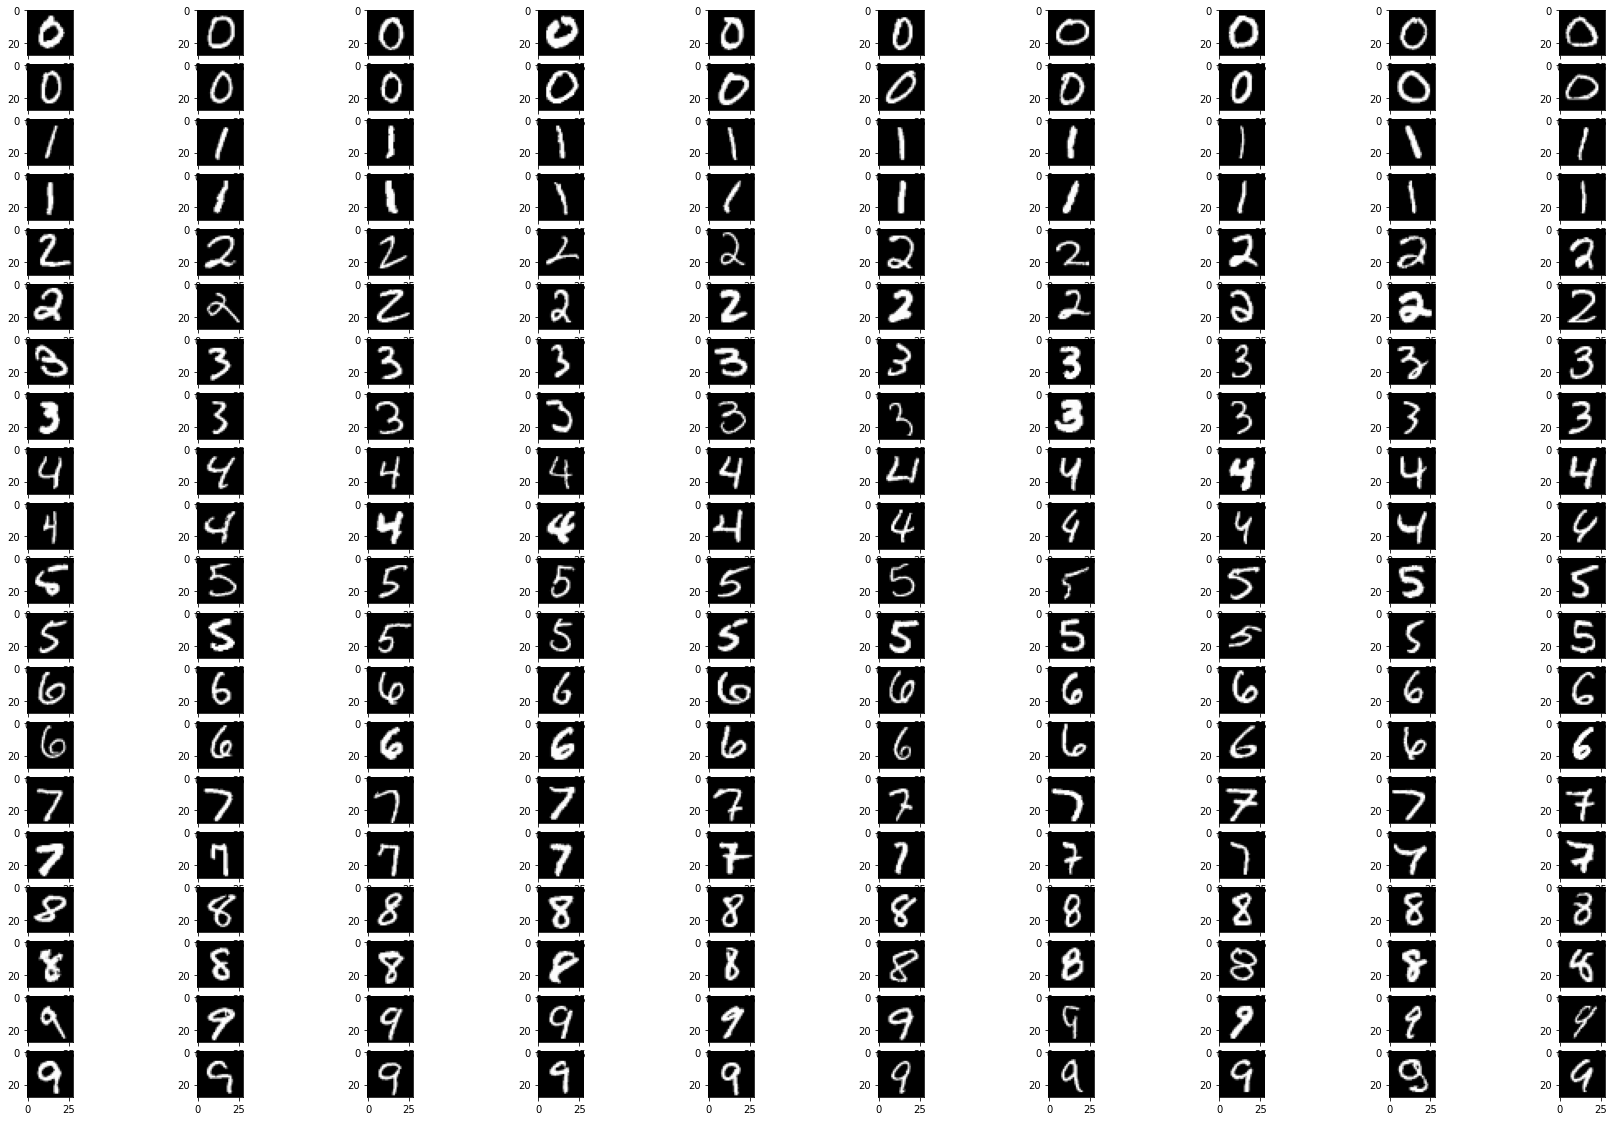

In [58]:
plt.figure(figsize=(30,20))
for i in range(200):
    plt.subplot(20,10,i+1)
    plt.imshow(selected_test_images_NP[i],"gray")

<h1 style='color:#134f5c'>Définition des fonctions necéssaires:</h1>

In [56]:
# focntion qui reçoit un tuple d'images et les affiche côte à côte
def showsbs(image_tuple):
    for i in range(len(image_tuple)):
        plt.gray()
        plt.subplot(1,len(image_tuple),i+1)
        plt.imshow(image_tuple[i])

# focntion qui calcule la matrice des indices à partir de la matrice des distances
def matrice_indice(mat):
    m_indice_texture=np.argsort(mat,axis=1)
    return m_indice_texture

# fcontion qui calcule la matrice binaire à partir de la matrice d'indices
def matrice_binaire(mat_indice):
    nl,nc=mat_indice.shape
    mat_indiceb=np.zeros((nl,nc))
    classe=0
    for i in range(nl):
        for j in range(nc):
            if mat_indice[i,j]>=classe and mat_indice[i,j]<classe+20:
                mat_indiceb[i,j]=1
            else:
                mat_indiceb[i,j]=0
        if  i%80==79:
            classe+=20
    return mat_indiceb

# focntion qui calcule la matrice des précisions à partie de la matrice binaire
def precision(matrice):
    nl=matrice.shape[0]
    nc=matrice.shape[1]
    p=np.zeros((nl,nc))
    for i in range(nl):
        for j in range(nc):
            count=np.count_nonzero(matrice[i][0:j+1])
            p[i,j]=count/(j+1)
    
    return p

# focntion qui calcule la précision moyenne
def precision_moyenne(matrice):
    nl=matrice.shape[0]
    nc=matrice.shape[1]
    M_P=precision(matrice)
    list_p=[]
    count=0
    for i in range(nl):
        for j in range(nc):
            if matrice[i,j]==1:
                list_p.append(M_P[i,j])
                count+=1
    moyenne=sum(list_p)/count
    return moyenne                

<h1 style='color:#134f5c'>Construction des descripteurs:</h1>

### 1) Dilatation et érosion:

On a commencé par appliquer une dilatation et une érosion sur notre base d'images. le choix du noyau est basé sur plusieurs tests pour determiner les noyaux qui donne les meilleurs résultats.

#### DILATATION:

Pour la dilatation on a utilisé la fonction prédéfinie <strong>cv2.dilate()</strong> de la bibliothèque OpenCV avec un noyau de taille $3*5$.<br>
La fonction suivante prend en argument un array d'images + le noyau et retourne un array d'images dilatées.

In [29]:
def dilate_array(images_array, kernel):
    dilated_images_list = []
    for img in images_array:
        dilated_images_list.append(cv2.dilate(img.astype(np.uint8), kernel))
    return np.array(dilated_images_list)

Application de la dilatation sur l'ensemble d'entrainement et de test respectivement:

In [30]:
d_kernel = np.ones((3,5)).astype(np.uint8)
dilated_train_images = dilate_array(selected_train_images_NP, d_kernel)
dilated_test_images = dilate_array(selected_test_images_NP, d_kernel)

Visualisation d'une image dilatée,

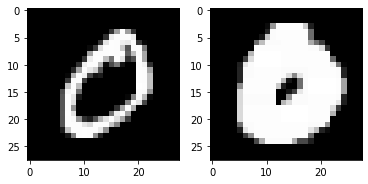

In [31]:
showsbs((selected_train_images_NP[0], dilated_test_images[0]))

#### EROSION:

pour l'érosion on a opté pour la fonction <strong>cv2.erode()</strong> avec un noyau de taille $2*3$.<br>
La fonction suivante prend en argument un array d'images + le noyau et retourne un array d'images érodées.

In [32]:
def erode_array(images_array, kernel):
    eroded_images_list = []
    for img in images_array:
        eroded_images_list.append(cv2.erode(img.astype(np.uint8), kernel))
    return np.array(eroded_images_list)

Application de l'érosion sur l'ensemble d'entrainement et de test respectivement:

In [33]:
e_kernel = np.ones((2,3)).astype(np.uint8)
eroded_train_images = erode_array(selected_train_images_NP, e_kernel)
eroded_test_images = erode_array(selected_test_images_NP, e_kernel)

Visualisation d'une image érodée,

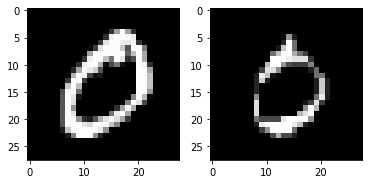

In [34]:
showsbs((selected_train_images_NP[0], eroded_test_images[0]))

### 2) Histogramme de gradient orienté (HOG):

L'histogramme de gradients (HOG) est une approche bien connue dans le domaine de la vision par ordinateur qui peut fournir des descriptions de caractéristiques pour une image donnée.<br>
    Une fenétre glissante est deplacée sur une image donnée et l'orientation de chacun des pixels est capturée dans la fenetre glissante. Ces orientations sont aussi appelées gradients et tous les gradients d'une fenetre glissante forment un vecteur gradient. Ces vecteurs de gradient sont utilisée pour former un histogramme qui reduit considérablement les dimensions de la matrice du vecteur de gradient 

Pour trouver l'Histogramme des gradients orientés on commence par calculer le gradient dans la direction x et y pour chaque image.

Le gradient dans la direction x se calcule par $g _{x}[i,j]=img[i+1,j]-img[i-1,j]$<br>

et se calcule dans la direction y par $g _{y}[i,j]=img[i,j+1]-img[i,j-1]$

Voici une Visualisation du gradient calculé dans les deux directions,

In [35]:
# La fonction cv2.sobel() est utilisé pour calculer le gradient dans une direction
ksize = 3
gX = cv2.Sobel(selected_test_images_NP[1].astype('uint8'), ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(selected_test_images_NP[1].astype('uint8'), ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
# la focntion cv2.convertScaleAbs() est utilisé pour avoir des valeurs en 8-bits
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)

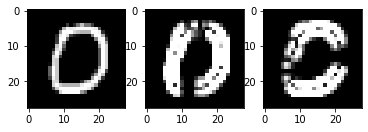

In [36]:
showsbs((selected_test_images_NP[1],gX,gY))

Après avoir calculé le gradient dans les deux directions, il faut calculer la magnitude 
 $G = \sqrt{ g_{x} +  g_{y}}$<br><br>
et l'angle du gradient     $ \theta=arctan \frac{ g_{x}}{ g_{y}}$ <br><br>
<strong>Remarque: </strong>la magnitude augmente lorsqu'il y a un changement brusque d'intensité.<br><br>
Le but de ces calculs est d'avoir, pour tout les pixels de l'image, les angles de gradients et la magnitude afin de pouvoir calculer leurs occurrences dans les differentes régions de l'image.

L'étape suivante consiste à diviser l'image en cellules et blocs tel que chaque cellule contient $n*n$ pixels et chaque bloc contient $m*m$ cellues, Pour chaque cellule, on calcule un histogramme de gradients.
L'histogramme contient géneralement 9 bacs correspondants à un intervalle d'angles de 0 à 160 en incréments de 20.<br><br>

<table style='width:600px'>
    <tr>
        <td>0</td>
        <td>20</td>
        <td>40</td>
        <td>60</td>
        <td>80</td>
        <td>100</td>
        <td>120</td>
        <td>140</td>
        <td>160</td>
    </tr>
    <tr>
        <td>-</td>
        <td>-</td>
        <td>-</td>
        <td>-</td>
        <td>-</td>
        <td>-</td>
        <td>-</td>
        <td>-</td>
        <td>-</td>
    </tr>
    
</table><br>
Le choix du bac à remplir est determiné par l'angle de gradient du pixel considéré, Alors que la valeur affecté à ce bac est determiné par la magnitude du pixel concerné multiplié par un poid $w_{i}$ à calculer.<br>
Le poid dépend de la proximité du grandient du pixel concerné des angles les plus proches dans l'histogramme. Cela veut dire que pour une angle de $36^\circ$, situé entre $20^\circ$ et $40^\circ$, et une magnitude de $G = 13.6$ on aura les champs $20^\circ$ et $40^\circ$ de l'histogramme qui sont respectivements remplis par    $ w_{20} =  13.6*\frac{40-36}{20}$ et  $ w_{40} = 13.6*\frac{36-20}{20}$<br>
Le poid $w_{40}$ est supérieur à $w_{20}$ car $36^\circ$ est plus proche de $40^\circ$.

<table style='width:600px'>
    <tr>
        <td >0</td>
        <td>20</td>
        <td>40</td>
        <td>60</td>
        <td>80</td>
        <td>100</td>
        <td>120</td>
        <td>140</td>
        <td>160</td>
    </tr>
    <tr>
        <td></td>
        <td>2.72</td>
        <td>10.88</td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>
    </tr><br>
</table>

cela fait, on aura pour chaque bloc de $m*m$ cellules un vecteurs de $m*9$ valeurs. C'est-à-dire que pour un bloc de $4*4$ cellues on aura un vecteur de $36$ valeurs.<br>
Pour éviter les problémes entrainés par les variations de luminosité, il est impératif de normaliser les vecteurs de chaque bloc. Bien qu'il ya plusieurs façons pour normaliser, on a chosit d'utliser la normalisation <strong>L1-sqrt</strong> qui consite à appliquer la formule suivante sur les vecteurs d'un bloc (les $m$ vecteurs du bloc sont combinés en un seul vecteur $v$):<br>
$ L1 -norm :  \sqrt\frac{v}{(\mid\mid v \mid\mid+e)}$<br>
avec $e$ une valeur négligeable pour éviter la division par zero.

A la fin de la procédure on obtient un vecteur descripteur de taille $n^2*m^2*nombre d'orientations$<br>

Visualisons le résultat du HOG appliqué sur une image de la mnist:
 


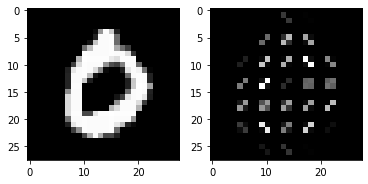

In [37]:
descripteur, visualisation = hog(selected_test_images_NP[0],orientations=4,pixels_per_cell=(4,4),cells_per_block=(5,5),block_norm='L1-sqrt',visualize=True,feature_vector=True)
showsbs((selected_test_images_NP[0],visualisation))

Pour imlémenter le HOG dans python on a choisit d'utiliser la focntion <strong>hog()</strong> de la bibliothèque skimage (importé en haut). la fonction prend en argument une image, le nombre des orientations, la taille des cellues, la taille des blocs, la méthode de normalisation, et retourne un vecteur descripteur de l'image si le parametre feature_vector est égale a True.<br>
Le nombre d'orientations ainsi que La dimension des cellules et des blocs ont été principalement déterminés par essais et erreurs. Comme le montre la focntion ci-dessus, on a opté pour 4 orientations, des cellues de $4*4$ et des blocs de $5*5$.

La fonction <strong>get_hog_vector()</strong>, applique simplement le Hog sur une image et retourne le vecteur descripteur:

In [38]:
def get_hog_vector(img):
    I=img
    hogImage=hog(I,orientations=4,pixels_per_cell=(4,4),cells_per_block=(5,5),block_norm='L1-sqrt',visualize=False,feature_vector=True)
    return hogImage

dans ce qui suit, pour constuire une matrice de descripteurs pour un array d'images, on utilisera la focntion <strong>matrice_desc_hog()</strong>:

In [39]:
def matrice_desc_hog(array_img):
    matrice_desc=[]
    for i in range(len(array_img)):
        matrice_desc.append(get_hog_vector(array_img[i]))
    return np.array(matrice_desc)

Pour le moment, on se trouve avec 3 bases d'images, la base des images originale, la base des images dilatées et la base des images érodées. L'idée principale est de calculer le HOG pour les 3 bases, calculer la matrice distance pour chacune, et combiner entre elles en multipliant par des poids pour pouvoir trouver une précision moyenne optimale.

construction de la matrice des descripteurs pour les images d'entarinement et de test respectivement de la base des images originale:

In [40]:
hog_train_images = matrice_desc_hog(selected_train_images_NP)
hog_test_images = matrice_desc_hog(selected_test_images_NP)

construction de la matrice des descripteurs pour les images d'entarinement et de test respectivement de la base des images dilatées:

In [41]:
hog_dilated_train_images = matrice_desc_hog(dilated_train_images)
hog_dilated_test_images = matrice_desc_hog(dilated_test_images)

construction de la matrice des descripteurs pour les images d'entarinement et de test respectivement de la base des images érodées:

In [42]:
hog_eroded_train_images = matrice_desc_hog(eroded_train_images)
hog_eroded_test_images = matrice_desc_hog(eroded_test_images)

<h1 style='color:#134f5c'>Calcul des matrices des distances et précision moyenne:</h1>

In [43]:
# focntion qui calcule la distance euclidienne entre deux vecteurs
def L2(yhat, y):
    loss = np.sqrt(np.sum((y-yhat)**2))
    return loss
# focntion qui recoit les matrices des descripteurs et calcule la matrice de des distances
def matrice_distance(test,train):
    matrice_distance_texture=np.ones((800,200))
    for i in range(0,800):
        for j in range(0,200):
            matrice_distance_texture[i,j]=L2(train[i,:],test[j,:])
    return matrice_distance_texture

La Matrice distance realtive au HOG appliqué sur la base d'images originale:

In [44]:
distance_matrix = matrice_distance(hog_test_images, hog_train_images)

La Matrice distance realtive au HOG appliqué sur la base d'images dilatées:

In [45]:
dilation_distance_matrix = matrice_distance(hog_dilated_test_images, hog_dilated_train_images)

La Matrice distance realtive au HOG appliqué sur la base d'images érodées:

In [46]:
erosion_distance_matrix = matrice_distance(hog_eroded_test_images, hog_eroded_train_images)

Après le calcul des trois matrices de distances, Nous procédons à les sommer en multipliant chacune d'elles par un poid afin d'obtenir une nouvelle matrice qu'on peut utiliser pour calculer la précision moyenne. Bien qu'il est difficile de déterminer, de manière objective, l'importance relative de chacun des caractéristiques, on a essayé de trouver une combinaison qui donne un meilleur resultat que chacun des descripteurs utilisés seul.

In [47]:
combined_distance_matrix = distance_matrix*0.4 + dilation_distance_matrix*0.5 + erosion_distance_matrix*0.1

calcul de la matrice des indices et la matrice binaire,

In [50]:
index_matrix = matrice_indice(combined_distance_matrix)
binary_matrix = matrice_binaire(index_matrix)

Finalement, on obtient une précision moyenne de:

In [54]:
precision_moyenne(binary_matrix)

0.6083976491157427